# 16024652 Final Assignment 
## 20th February 2018

In [1]:
# importing modules with useful shorthand to save time and space in code
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
from IPython.display import Image

%matplotlib notebook

In this notebook we will be solving the one-dimensional time-independent Schrödinger equation [1]:

$$ -\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x) $$

$\hbar = \text{reduced Planck constant (Js)}\\
\psi(x) = \text{wavefunction}\\
V(x) = \text{potential energy of the system (J)}\\
E = \text{total energy (J)}\\
m = \text{particle mass (kg)}$

for varying wavefunctions and boundary problems. This equation allows us to compute the wavefunction of a system which is essentially a mathematical description of the quantum state of the system. From this we can find the probability of finding a given particle at a particular point in a space. It also allows us to find the energy eigenvalues of the system. 

# 1. Infinite Square Well

The infinite square well is a  system given by:
$$ V_x = \begin{cases} 0 & \text{if } -a < x < +a, \\ 
\infty  & \text{if } |x| > a, \end{cases} 
$$

which describes a particle free to move in a box but bounded by potential walls. The particle cannot move into the regions where this potential is infinite and therefore we are given boundary condition that $\psi=0$ at $x=-a,+a$ for the wavefunction, allowing us to solve the Schrödinger equation above.

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Infinite_potential_well_2.PNG">

To begin to solve for this system we must first define a few useful constants.

In [2]:
m = 9.10938356e-31                # electron mass in kg
hbar = 1.0545718e-34              # h bar (reduced Planck constant) in Js
e = 1.60217662e-19                # electron charge in C
a = 5e-11                         # half width potential in m

N = 1000                          # number of Runge-Kutta calculation points
h = (2*a)/N                       # Runge-Kutta step size 
xpoints = np.arange (-a, a, h)    # creating an array of x values beween boundary condition

In [3]:
def V(x):
    '''Returns value for potential V as zero for any given x inside an infinite square well.
    Inputs: x, a value or array of x values 
    Returns: potential, 0.0
    '''
    return 0.0

As the one-dimensional Schrödinger equation is a second order differential equation it is sensible to separate it out into two first order differential equations to make it easier to solve. This separation gives:

$$
\frac{d \psi}{dx } = \phi, \\
\frac{d \phi}{dx } = \frac{2m}{\hbar^2} \left[V(x) - E \right] \psi(x),
$$

As previously mentioned we know that $\psi = 0$  at $x=-a$ therefore we can simply guess an initial condition for $\phi$ to begin with.

In [4]:
phi = 1.0                         # random initial guess for phi
psi = 0                           # initial value for wavefunction, we know it is 0 at boundary
r = [psi, phi]                    # array of initial psi and phi values

In [5]:
def f(r, x, E):
    ''' Definition of our numerical function to calculate psi and phi (right hand 
    side of each separated Schrodinger equation) and place them in an array.
    Inputs: r, an array of initial psi and phi  
            x, a value or array of x values
            E, a value for energy in J
    Returns: Array of each RHS of separated Schrodinger equation. 
    '''
    psi = r[0]                              # placing psi and phi in 0th and 1st elements of r array
    phi = r[1] 
    dpsi = phi                              # calculating RHS of given equations     
    dphi = 2* m * (V(x)-E) * psi / (hbar**2)
    return np.array([dpsi,dphi]) 

We now must find approximate solutions for these ordinary differential equations. This is done using the fourth order Runge-Kutta method [2] which uses the weighted sum of four approximations of a slope to estimate the slope between two given points. Done iteratively this gives a complete solution for the given differential equation.

In [6]:
def RK4(r,xpoints,E):
    '''Fourth-order Runge Kutta. 
    Inputs: initial r, array of x points and energy E in J
    Also depends on step h (global variable) and
    requires the function f(r, x, E) to be defined.
    Returns: array of propagated psi points representing the wavefunction'''

    # initialising empty array for results
    psi_points = []
    
    # now we iterate within the range of given xpoints
    for x in xpoints:
        psi_points.append(r[0])               # append the current value of psi to the return array 
        k1 = h*f(r,x,E) 
        k2 = h*f(r + 0.5*k1, x + 0.5*h, E)
        k3 = h*f(r + 0.5*k2, x + 0.5*h, E)
        k4 = h*f(r + k3, x + h, E)
        r = r + (k1 + 2*k2 + 2*k3 + k4)/6     # this is the value of r at this x point
    psi_points.append(r[0])
    # return array of wavefunction points
    return np.array(psi_points)  

So we now have a Runge-Kutta function that uses a given energy to produce a wavefunction, however we might not always know which energy we want to use in this function. To work out if we have the correct wavefunction we can utilise the boundary conditions again.

We make a random guess at an energy, use that in the Runge-Kutta function to calculate a wavefunction, and then see if the boundary conditions are met, so if the initial or final points of the array are 0 (where $x=-a,+a$). We can then make another guess and see if the final point here is 0. If neither of these give the boundaries we expect the secant method [2] will then be initiated to converge on the boundary condition root. 

This is done by approximating the gradient at a point and guessing a root position from iterating the tangents to the curve.

We must first also set a tolerance for so that our looped calculation will stop when the best estimate of our calculated root position changes by less than this amount. 

In [7]:
def E_secant(E1,E2,n):
    '''Secant method
    Inputs: E1 and E2, two initial guesses for energy (eV)
            n, quantum number, any positive integer
    Also requires the function RK4 to be defined.
    Returns: E3, energy found via secant method (J) '''
       
    psi = 0
    r = [psi,phi]
    
    tolerance = e/1000   # cut off point for error after which iteration stops
    err = 1              # initial error for secant method
    
    # converting energies into SI units (J)
    E1 = E1 * e
    E2 = E2 * e
    
    # solve for initial first and second guesses 
    soln1 = RK4(r, xpoints, E1)[N]
    soln2 = RK4(r, xpoints, E2)[N]
   
    while err > tolerance:
        
        E3 = E2 - soln2*(E2 - E1)/(soln2 - soln1)
        err = abs(E2-E1) 
        # reset initial energies for the next iteration
        E1 = E2 
        E2 = E3 
        
        # and recalculate wavefunction solutions
        soln1 = RK4(r, xpoints, E1)[N]
        soln2 = RK4(r, xpoints, E2)[N]
     
    return E3

Before using the secant method to calculate our energy we can use the known equation for energy in the infinite square well to produce a value for which we can guess around in the secant method. This equation for an infinite square well is [1]:

$$
E_n = \frac{\pi^2 \hbar^2 n^2}{2m (2a)^2}
$$

In [8]:
def E_expected(n):
    '''Function to calculate the expected energies for a particle 
    inside an infinite square well.
    Inputs: n, quantum number,  any positive integer
    Also requires the function RK4 to be defined as well as variables
    m (particle mass) and a (well width).
    Returns: E, expected energy (J) '''
    
    E = (((np.pi)**2)*(hbar**2)*(n**2))/(2*m*4*(a**2))
   
    return E

In [9]:
# calculating ground state expected energy

print('The expected ground state energy is {:.5e} J or {:2.3f} eV'.format(E_expected(1),E_expected(1)/e))

The expected ground state energy is 6.02467e-18 J or 37.603 eV


In [10]:
# we can now input guesses for the energy from above expected energy
# to see if the secant method produces a value near our expected energy

print('The calculated ground state energy is {:.5e} J or {:2.3f} eV'.format(E_secant(30,40,1), E_secant(30,40,1)/e))

The calculated ground state energy is 6.02467e-18 J or 37.603 eV


In order to calculate and plot any wavefuntions we first need to define a function to normalise any wavefunctions we output. In this normalisation it is also useful to include a relevant sign rule as due to superposition there are many valid solutions to the wavefuntion at each principle quantum number and energy, however we will aim for the one that is most commonly accepted in each case.

We will therefore normalise via the Born rule [1]:

$$
\int | \psi(x) |^2 {\rm d} x = 1
$$

Instead of a complicated full integration we will use the trapezium rule [2] to integrate the squared wavefuntion and therefore find the necessary integration constant that will normalise the wavefunction: 

$$
I(a,b) = h \left[ \frac{1}{2}f(a) + \frac{1}{2}f(b) +
      \sum_{k=1}^{n-1}f(x + kh) \right]
$$

In [11]:
#############################################################
# PLEASE NOTE T (type) may be:
# 1: infinite square well
# 2: infinite harmonic well
# 3: finite square well
#############################################################

def normalise(g, n, T):
    '''Function to normalise a wavefuntion and assign appropriate sign.
    Inputs: g, function to be normalised
    n, quantum number,  any positive integer
    T, type of function to be normlised, may be '1' (infinite square
    well), '2' (infinite harmonic well) or '3' (finite square well) 
    Requires N (number of Runge-Kutta points) to also be defined.
    Returns: Normalised array of wavefunction points '''
    
    w = np.square(np.abs(g))                               # finding the square of the modulus of the wavefunction
                                                           # and then its square
    I = h * (0.5*w[0] + 0.5*w[N] + np.sum(w[1:N-1]))     # calculating integral via trapzium rule 
    
    if T == 1 or T == 3:
        sign = (-1)**(np.floor(n/2))
    elif T == 2:
        sign = (-1)**(n)
        
    norm = (g[0:N] / (I**0.5)) * sign
    
    return norm 

To check whether all of our functions work, we can compare our results for the infinite square well to the known expected wavefuntions for odd and even principle quantum numbers [3].

$$
\psi_n(x)  = \frac{1}{\sqrt{a}} \cos\left(\frac{ n \pi x}{2a}\right) \qquad 
    n \ \mathrm{odd}
    $$
    $$
    \psi_n(x)  = \frac{1}{\sqrt{a}} \sin\left(\frac{ n \pi x}{2a}\right) \qquad
    n \ \mathrm{even}.
$$

In [12]:
def expected_psi(n):
    '''Function to calculate the expected wavefunction for an infinite square well.
    Inputs: n, quantum number,  any positive integer
    Requires xpoints (array of x values) and a (well width) to also be defined.
    Returns: Normalised array of expected wavefunction points '''
    
    if n % 2 == 0:
        psi_e = np.sin((n*np.pi*xpoints) / (2*a))*a**-0.5
    else:
        psi_e = np.cos((n*np.pi*xpoints) / (2*a))*a**-0.5 
    
    return(psi_e)

Before potting any wavefuntions, for ease of use and time saving we will define a plot function that should plot any graph we require for any potential.

In [13]:
def plot_limits(T):
    '''Function to plot axes lines on a graph at values depending on type.
    Inputs: T, type of function to be normlised, may be '1' (infinite square
    well), '2' (infinite harmonic well) or '3' (finite square well) 
    Requires 'a', well width to also be defined.
    Returns: axes plots at necessary points'''
    
    # plotting the borders of the potential well depending on potential type
    if T == 1 or T == 2:
        plt.axvline(x=-a,c='k',ls=':',lw=2)
        plt.axvline(x=a,c='k',ls=':',lw=2)
    if T == 3:
        plt.axvline(x=-a/2,c='k',ls=':',lw=2)
        plt.axvline(x=a/2,c='k',ls=':',lw=2)

    # plotting axes lines at x = 0 and y = 0
    plt.axhline(c="k", ls="-", lw=0.25)
    plt.axvline(x=0,c='k',ls='-',lw=0.25)



def plot(E1, E2, n, T):
    '''Function to plot a given wavefunction.
    Inputs: E1 and E2, two initial guesses for energy (eV) 
    n1, initial quantum number to plot,  any positive integer
    n2, final quantum number to plot,  any positive integer
    T, type of function to be normlised, may be '1' (infinite square
    well), '2' (infinite harmonic well) or '3' (finite square well) 
    Requires xpoints (array of x values) and a potential to also be defined.
    Returns: labelled plot of normalised wavefunctions with expected wavefunctions
    if necessary'''
    
    plt.figure(figsize=(9.5,7.5))
    
        
    # finding required energy and therefore wavefunction points
    E3 = E_secant(E1,E2,n)
    g = RK4(r, xpoints, E3)
    
    # plotting the borders of the potential well depending on potential type
    plot_limits(T)


    # plotting normalised wavefunctions
    plt.plot(xpoints,normalise(g,n, T),'m', label='$Calculated$') # Plot the normalised wavefunction solution
    
    # plotting expected wavefunctions if known
    if T == 1:
        plt.plot(xpoints,expected_psi(n), 'k--', label="$Expected$")

    # titling the graph
    if n == 1 and T == 1:
        plt.title('$Ground\ State\ Wavefunction\ for\ the\ Infinite\ Square\ Well$', fontsize=18)
    elif n != 1 and T == 1:
        plt.title('$n = {}\ State\ Wavefunction\ for\ the\ Infinite\ Square\ Well$'.format(n), fontsize=18)
    elif n == 1 and T == 2: 
             plt.title('$Ground\ State\ Wavefunction\ for\ the\ Infinite\ Harmonic\ Well}$', fontsize=18)
    elif n != 1 and T == 2:
            plt.title('$n = {0} \State \Wavefunction \for \the \Infinite \Harmonic \Well$'.format(n), fontsize=18)
    elif n == 1 and T == 3:
             plt.title('$Ground\ State\ Wavefunction\ for\ the\ Finite\ Square\ Well$', fontsize=18)        
    elif n != 1 and T == 3:
             plt.title('$n = {0} \State \Wavefunction \for \the \Finite \Square \Well$'.format(n), fontsize=18) 
    
    # labelling the graph and plotting a legend
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$\psi(x)$', fontsize=20)
    
    ax = plt.subplot(111)
    plt.legend(loc=0)

    # maxing axes smaller to allow for legend to be plotted underneath
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # plot legend underneath axes
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

In [14]:
def plot_all(array, n1, n2, T):
    '''Function to plot any amount of n for a given wavefunction.
    Inputs: array, array of energy values (eV) for given n
    n1, initial quantum number to plot,  any positive integer
    n2, final quantum number to plot,  any positive integer
    T, type of function to be normlised, may be '1' (infinite square
    well), '2' (infinite harmonic well) or '3' (finite square well) or '4'
    (finite potential well with other potential)
    Requires xpoints (array of x values) and a potential to also be defined.
    Returns: labelled plot of normalised wavefunctions for given n'''
    
    # setting figsize 
    plt.figure(figsize=(9.5,7.5))
    
    # creating array of n values
    if n2 - n1 == 1:
        n_array = [n1,n2]
        L = len(n_array)
    else:
        n_array = np.arange(n1-1,n2,1)
        L = len(n_array)
        
    # initialising counters
    i = 0
    j = 0
    for j in range (n_array[0],L):
        n = n_array[j]
        E1 = array[i]
        E2 = array[i+1]
        E3 = E_secant(E1,E2,n)
        g = RK4(r, xpoints, E3)
    
        # plotting the borders of the potential well depending on potential type
        plot_limits(T)

        # plotting normalised wavefunctions
        if T == 2:
            plt.plot(xpoints,normalise(g,n, T), label='$n = {0}$'.format(n)) # Plot the normalised wavefunction solution
        else:
            plt.plot(xpoints,normalise(g,n, T), label='$n = {0}$'.format(n+1)) 
            
    
        if T == 1:
            plt.title('$\ Calculated\ Wavefunctions\ for\ the\ Infinite\ Square\ Well$', fontsize=18)
        if T == 2: 
            plt.title('$\ Calculated\ Wavefunctions\ for\ the\ Infinite\ Harmonic\ Well\ With\ V_0 = {0}eV$'.format(V0), fontsize=18)
        if T == 3:
            plt.title('$\ Calculated\ Wavefunctions\ for\ a\ Finite\ Square\ Well\ With\ V_0 = {0}eV$'.format(V0), fontsize=18)       
        if T == 4:
            plt.title('$\ Calculated\ Wavefunctions\ for\ a\ Finite\ Well\ With\ V_0 = {0}eV$'.format(V0), fontsize=18)
            
        i += 2
        j+= 1
    
    # labelling the graph and plotting a legend
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$\psi(x)$', fontsize=20)
    
    ax = plt.subplot(111)
    plt.legend(loc=0)

    # Shrink current axis's height by 10% on the bottom 
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center',title = '$Principle\ Quantum\ Number$', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

Now we have all of our useful funtions defined, we can plot the ground state wavefunction for our infinite square well potential and see how it compares to our expected wavefunction.

<IPython.core.display.Javascript object>


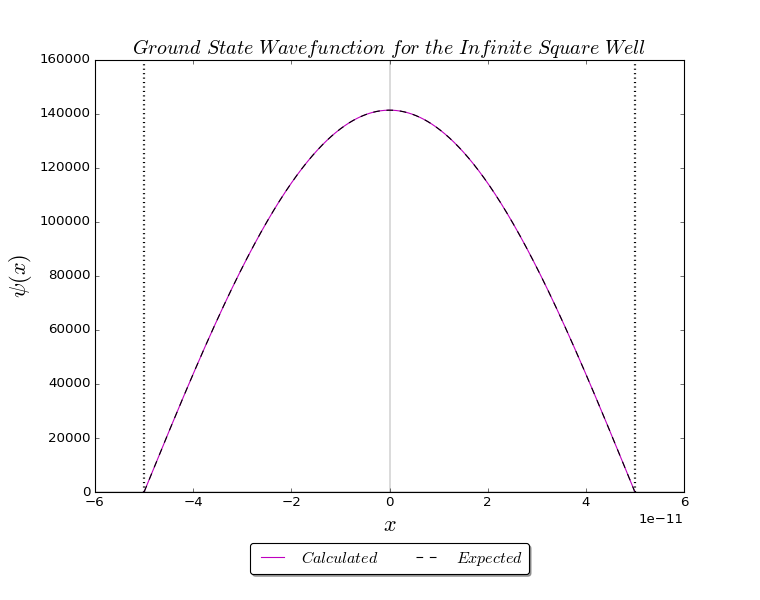

In [15]:
plot(30, 40, 1, 1)

It's a match! Now let us see if our calculations work equally well for other n values. In each case to find a sensible energy value to estimate around we will first calculate the expected energy as was done for the ground state calculatons. We will then enter these into our secant definition (range of about 10 eV around the expected value) and check if the result is simular to the expected result to verify this function works well for other n.

In [16]:
for i in [2,3,4,10,20]:
    print('The expected n = {} state energy is {:.5e} J or {:2.3f} eV'.format(i, E_expected(i),E_expected(i)/e))

The expected n = 2 state energy is 2.40987e-17 J or 150.412 eV
The expected n = 3 state energy is 5.42220e-17 J or 338.427 eV
The expected n = 4 state energy is 9.63947e-17 J or 601.648 eV
The expected n = 10 state energy is 6.02467e-16 J or 3760.302 eV
The expected n = 20 state energy is 2.40987e-15 J or 15041.206 eV


In [17]:
print('The calculated n = 2 state energy is {:.5e} J or {:2.3f} eV'.format((E_secant(145,155,2)),(E_secant(145,155,2))/e))
print('The calculated n = 3 state energy is {:.5e} J or {:2.3f} eV'.format((E_secant(330,350,3)),(E_secant(330,350,3))/e))
print('The calculated n = 4 state energy is {:.5e} J or {:2.3f} eV'.format((E_secant(590,610,4)),(E_secant(590,610,4))/e))
print('The calculated n = 10 state energy is {:.5e} J or {:2.3f} eV'.format((E_secant(3750,3770,10)),(E_secant(3750,3770,10))/e))
print('The calculated n = 20 state energy is {:.5e} J or {:2.3f} eV'.format((E_secant(15030,15050,20)),(E_secant(15030,15050,20))/e))

The calculated n = 2 state energy is 2.40987e-17 J or 150.412 eV
The calculated n = 3 state energy is 5.42220e-17 J or 338.427 eV
The calculated n = 4 state energy is 9.63947e-17 J or 601.648 eV
The calculated n = 10 state energy is 6.02467e-16 J or 3760.302 eV
The calculated n = 20 state energy is 2.40987e-15 J or 15041.210 eV


All the energies match to a good prescision. But what about the wavefunctions? Let's plot them using our estimated range of energy values and see.

<IPython.core.display.Javascript object>


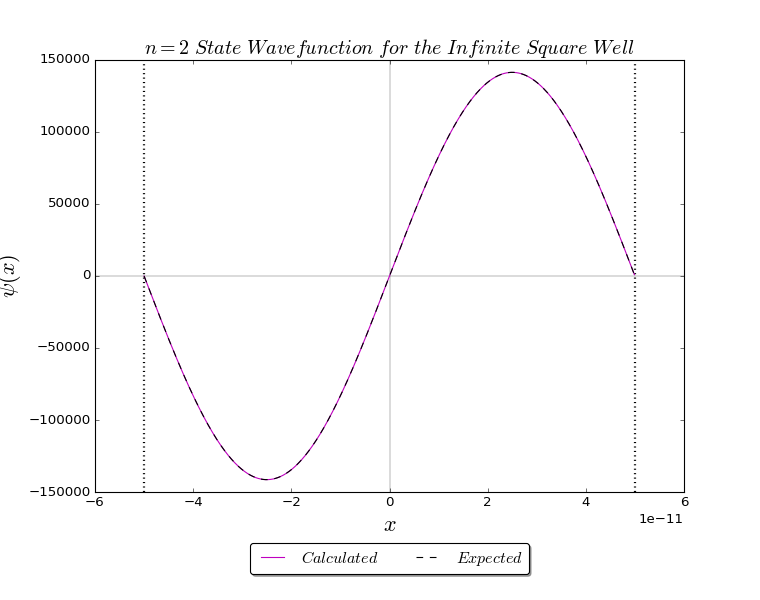

In [18]:
plot(145,155,2,1)

<IPython.core.display.Javascript object>


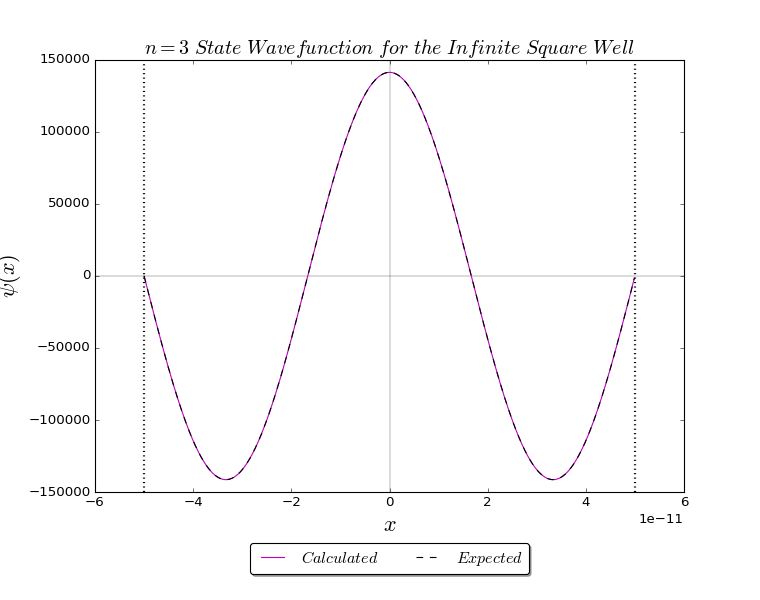

In [19]:
plot(330,350,3,1)

<IPython.core.display.Javascript object>


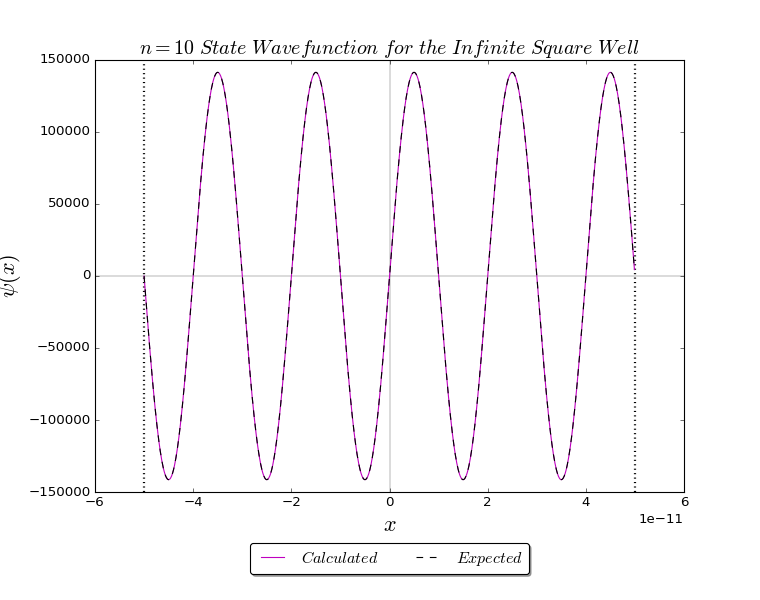

In [20]:
plot(3750,3770,10,1)

<IPython.core.display.Javascript object>


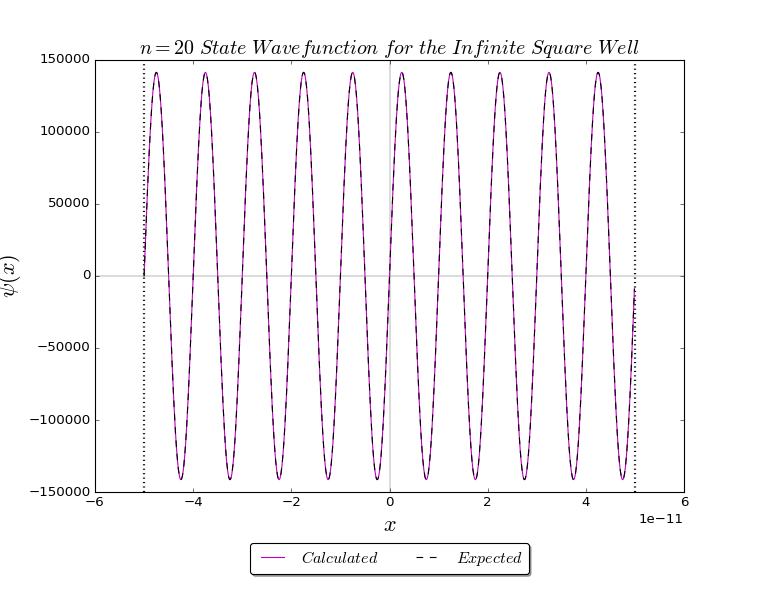

In [21]:
plot(15030,15050,20,1)

<IPython.core.display.Javascript object>


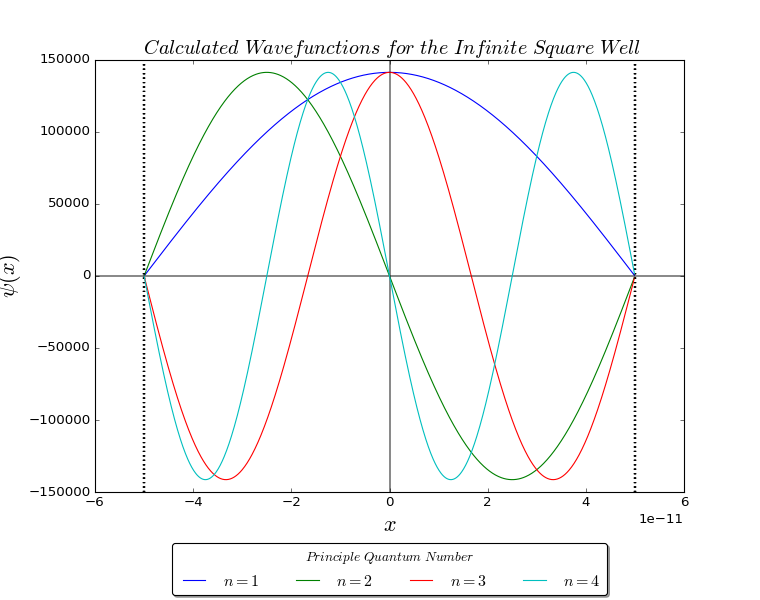

In [22]:
array = [30,40,145,155,330,350,590,610]
plot_all(array,1,4,1)

From these plots we can see that our calculated wavefunctions match our expected ones, even for large n. This therefore means both our secant and fourth-order Runge-Kutta definitions are working well (although we only know this for sure for this function). 

We can see that as n increases the 'wavelength' of the wavefunctions decrease. This is becuase the energy of each eigenstate is dependant on k, the wavenumber, which in itself is dependant on the reciprocal of the wavelength giving us the expected result that energy decreases with increasing wavelength. 

Now this is verified, we can move onto potentials for which we may not know the expected energies or wavefunctions. 

# Infinite Harmonic Well

We will now attempt to find solutions for a different potential embedded within the infinite square well: a harmonic potential. Due to the fact that the potential is still infinite outside of our allocated range, we may still keep the same boundary conditions as the previous potential and integrate as though the potential is bound. To start we will use a $V_0$ value of 800eV.  

Our new harmonic potential is:

$$ V_x = \begin{cases} V(x) = V_0 \frac{x^2}{a^2} & \text{if } -a < x < +a, \\ 
\infty  & \text{if } |x| > a, \end{cases} 
$$

The wavefunctions are given by the (rather complex!) equation [1]:

$$
\psi_n(x) = \frac{1}{\sqrt{2^n n!}}\left ({\frac{m\omega}{\pi\hbar}}\right )^{1/4} e^{-\frac{m\omega x^2}{2\hbar}} H_n\left (\sqrt{\frac{m\omega}{\hbar}}x\right ), \quad n=0,1,2,...
$$

Below I have plotted a harmonic potential, although it is not embedded within an infinite square well so will not match our calculated wavefunctions. However it might be interesting to compare the two, they should have simularities. I have also included a picture from an online source to validify both my expected and calculated wavefunctions.

In [23]:
def theorectical_harmonic(n, xpoints, V0):
    '''Function to calculate the expected wavefunction for a harmonic potenial.
    Inputs: n, quantum number,  any positive integer
            xpoints, an array of x points
            V0, potential (eV)
    Requires xpoints (array of x values) and a (well width) to also be defined.
    Returns: Normalised array of expected wavefunction points '''
    
    V0 = V0 * e
    V = V0*(np.square(xpoints))/(a**2)
    
    H_n = sp.special.hermite(n)
    omega = np.sqrt(2*V0 / m) / a
    Hpoints = xpoints * ((m*omega/hbar)**0.5)
    psi1 = (1/ np.sqrt(((2**n)*np.math.factorial(n)))) * ((omega/np.pi)**0.5) * np.exp(-np.square(Hpoints)/2) * H_n(Hpoints)
    w = np.square(np.abs(psi1))                               # finding the square of the modulus of the wavefunction
                                                              # and then its square
    I = h * (0.5*w[0] + 0.5*w[N-1] + np.sum(w[1:N-2]))        # calculating integral via trapzium rule
    # we have integrated manually as we do not require a sign change from our normalisation 
    norm = (psi1[0:N] / np.square(I))
    
    return norm

<IPython.core.display.Javascript object>


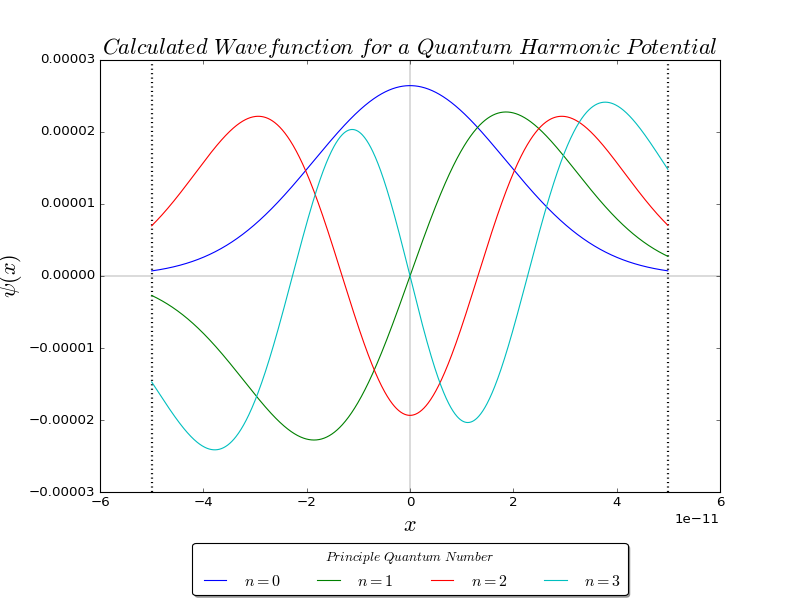

In [24]:
V0 = 800

# Plot the wavefunctions
plt.figure(figsize=(10,7.5))
plt.axvline(x=-a,c='k',ls=':',lw=2)
plt.axvline(x=a,c='k',ls=':',lw=2)
plt.axhline(c="k", ls="-", lw=0.25)
plt.axvline(x=0,c='k',ls='-',lw=0.25)

for n in range (0,4):
    plt.plot(xpoints,theorectical_harmonic(n, xpoints,V0), label='$n = {0}$'.format(n))
    
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$\psi(x)$', fontsize=20)
plt.title('$ Calculated \ Wavefunction \ for \ a \ Quantum \ Harmonic \ Potential  $', fontsize=20)
    
ax = plt.subplot(111)
plt.legend(loc=0)

# Shrink current axis's height by 10% on the bottom 
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center',title = '$Principle\ Quantum\ Number$', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

<img src="https://i.stack.imgur.com/RS6S2.png">

So my calculared wavefunctions and the verified wavefunctions from an online source are the same. Note the online source has used the notation of beginning with n = 1 not n = 0 but they are essentially the same plots.

In [25]:
# initial value for V0 in eV
V0 = 800
def V(x):
    '''Returns value for potential V for any given x over any range of x.
    Inputs: x, a value or array of x values
    Also requires electronic charge e and well width a to be defined as well as V0 (where
    curve meets x = a and -a)
    Returns: potential V in J
    '''
    
    if abs(x) > abs(a):
        V = 0
    else:
        V = V0 * e * (x**2 / a**2)
    
    return V

We can calculate the energy of the system using [3]: 

$$ E = \hbar \omega (n+\frac{1}{2}) $$

where 

$$ \omega = \sqrt{\frac{2V_0}{ma^2}} $$

In [26]:
def E_expected_h(V0, n):
    '''Function to calculate the expected energies for a particle with harmonic potential.
    Inputs: n, quantum number,  any positive integer
    V0, potential at boundary condition points 
    Also requires m (particle mass/ kg) and a (well width / m) to be defined.
    Returns: E, expected energy (J) '''
     
    V0 = V0 * e                           # converting V0 into SI units (J)
    
    omega = (2 * V0 / (m * a**2))**0.5    # s^-1
    E = hbar * omega * (n + 0.5)          # J
    
    return E

We can use this expected energy function to find the calculated energy eigenvalues and plot them with the energy eigenvalues. 

In [27]:
def E_diff(E1,E2,n):
    '''Returns value for the difference between expected and calculated energy values.
    Inputs: E1 and E2, two energy guesses in eV
    n, principle quantum number, any positive integer
    Also requires V0 (where curve meets x = a and -a) to be defined
    Returns: calculated energies with energy difference 
    '''
    # calculating expected energy
    print('The expected n = {} state energy is {:.5e} J or {:2.3f} eV'.format(n,E_expected_h(V0, n),E_expected_h(800,n )/e))
    E0 = E_secant(E1,E2,n)
    E0_e = E_expected_h(V0, n)
    # calculating calculated energy
    print('The calculated n = {:0} state energy is {:.5e} J or {:2.3f} eV'.format(n,E0,E0/e))
    # finding the difference between the two
    print('Difference of {:2.2f}% from expected'.format(100*np.abs(E0_e-E0)/E0_e))
    # printing an extra line for clear formatting
    print()
    
    return

In [28]:
V0 = 800

E_diff(105,115,0)
E_diff(320,340,1)
E_diff(540,560,2)
E_diff(760,780,3)
E_diff(2310,2330,10)
E_diff(4520,4530,20)

The expected n = 0 state energy is 1.76908e-17 J or 110.417 eV
The calculated n = 0 state energy is 1.77613e-17 J or 110.858 eV
Difference of 0.40% from expected

The expected n = 1 state energy is 5.30723e-17 J or 331.251 eV
The calculated n = 1 state energy is 5.39299e-17 J or 336.604 eV
Difference of 1.62% from expected

The expected n = 2 state energy is 8.84539e-17 J or 552.086 eV
The calculated n = 2 state energy is 9.30007e-17 J or 580.465 eV
Difference of 5.14% from expected

The expected n = 3 state energy is 1.23835e-16 J or 772.920 eV
The calculated n = 3 state energy is 1.38541e-16 J or 864.706 eV
Difference of 11.88% from expected

The expected n = 10 state energy is 3.71506e-16 J or 2318.760 eV
The calculated n = 10 state energy is 3.38433e-16 J or 2112.332 eV
Difference of 8.90% from expected

The expected n = 20 state energy is 7.25322e-16 J or 4527.102 eV
The calculated n = 20 state energy is 7.71968e-16 J or 4818.248 eV
Difference of 6.43% from expected



Our wavefunctions do not match the explar wavefunctions shown at the start of this section, although this is only due to the fact that unlike for the infinite square well we did not force the wavefuntion being 0 at $x = a$ and $- a$ so the wavefunctions will not necessarily cross the axes at these points, especially for higher n. However in comparing the shapes of our graphs to the expected they are very close in shape so we can assume they are correct. However they are not completely ideal, we can see from the energies that the expected and calculated do not match, and this gets increasingly divergant at high n. 

<IPython.core.display.Javascript object>


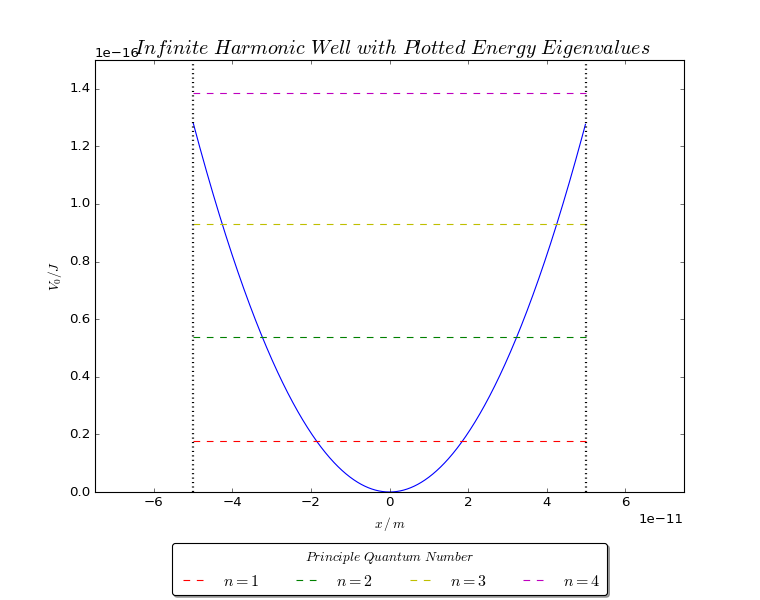

[5.3929916107839245e-17]


In [29]:
def V_energy(x):
    '''Returns value for potential V for any given x inside the limits of an infinite square well.
    Inputs: x, a value or array of x values
    Also requires electronic charge e and well width a to be defined as well as V0 (where
    curve meets x = a and -a)
    Returns: potential V in J
    '''
    
    V = V0* e * x**2 / a**2
    return V

plt.figure(figsize=(9.5,7.5))

# plotting potential
plt.plot(xpoints,V_energy(xpoints))

# calculating energy eigenvalues
y0 = [E_secant(105,115,0)]
y1 = [E_secant(320,340,1)]
y2 = [E_secant(540,560,2)]
y3 = [E_secant(760,780,3)]
print(y1)

# plotting energy eigenvalues
plt.axhline(y=y0, xmin=1/6, xmax=5/6, c="r", ls="--", label="$n = 1$")
plt.axhline(y=y1, xmin=1/6, xmax=5/6, c="g", ls="--", label="$n = 2$")
plt.axhline(y=y2, xmin=1/6, xmax=5/6, c="y", ls="--", label="$n = 3$")
plt.axhline(y=y3, xmin=1/6, xmax=5/6, c="m", ls="--", label="$n = 4$")

# plotting legend
ax = plt.subplot(111)

# resize current axes
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# plot a legend below the axes
ax.legend(loc='upper center',title = '$Principle\ Quantum\ Number$', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

plt.axvline(x=-a, c="k", ls=":",lw=2)           # draw black dotted line at x = -a
plt.axvline(x=a, c="k", ls=":",lw=2)            # draw black dotted line at x = a
plt.xlim(-1.5*a,1.5*a)                          # plot axes limits
plt.ylim(0,1.5e-16)

plt.xlabel("$x\,/\,m$")
plt.ylabel("$V_0 / J$")
plt.title('$\ Infinite\ Harmonic\ Well\ with\ Plotted\ Energy\ Eigenvalues$', fontsize=18)  

<IPython.core.display.Javascript object>


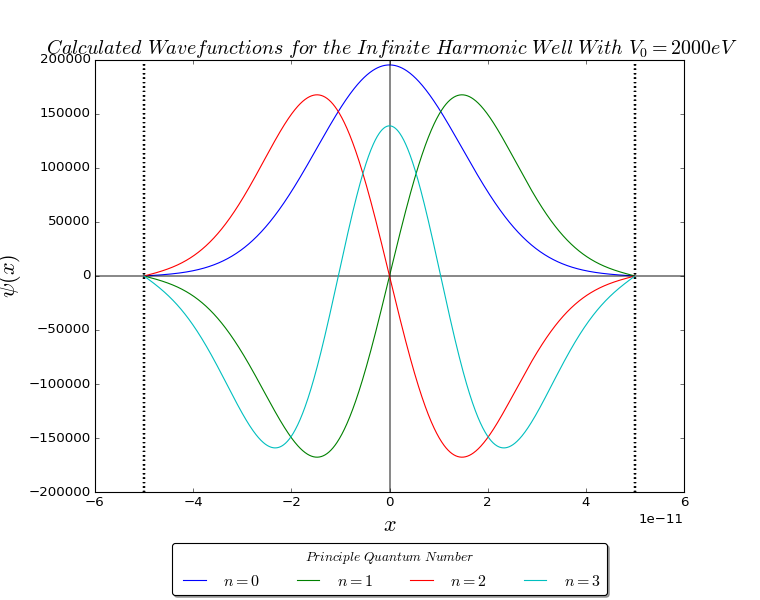

In [32]:
array = [100,120,325,340,550,590,770,870]
plot_all(array,1,4,2)

This graph looks simular to the ones we expect, so we will now try to vary V0 and see if our approximations still hold somewhat valid. We will first try a value far higher than the one we previously plotted

In [33]:
V0 = 2000

E_diff(170,180,0)
E_diff(515,530,1)
E_diff(870,880,2)
E_diff(1100,1300,3)

The expected n = 0 state energy is 2.79716e-17 J or 110.417 eV
The calculated n = 0 state energy is 2.79737e-17 J or 174.598 eV
Difference of 0.01% from expected

The expected n = 1 state energy is 8.39147e-17 J or 331.251 eV
The calculated n = 1 state energy is 8.39589e-17 J or 524.030 eV
Difference of 0.05% from expected

The expected n = 2 state energy is 1.39858e-16 J or 552.086 eV
The calculated n = 2 state energy is 1.40261e-16 J or 875.441 eV
Difference of 0.29% from expected

The expected n = 3 state energy is 1.95801e-16 J or 772.920 eV
The calculated n = 3 state energy is 1.97965e-16 J or 1235.603 eV
Difference of 1.11% from expected



These energy values are much closer, even for higher n. This seems to imply at high $V_0$ our function becomes more simular to expected values.

<IPython.core.display.Javascript object>


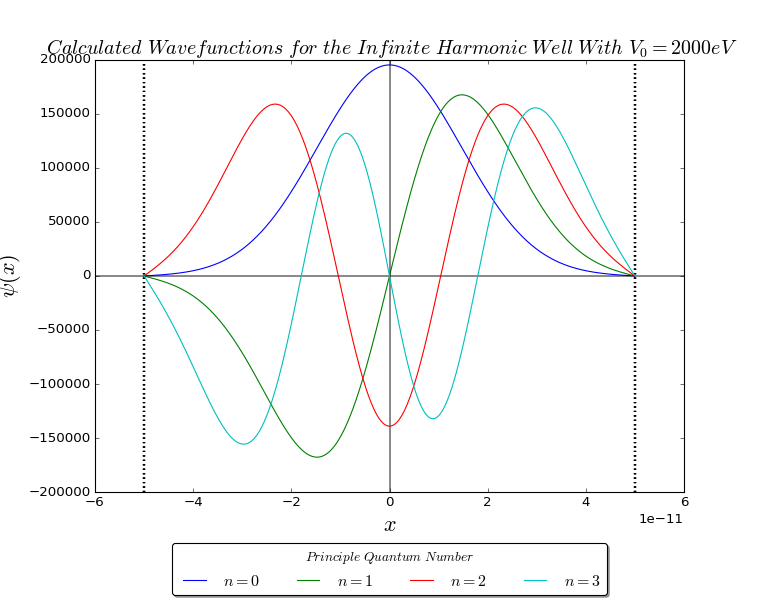

In [34]:
array = [100, 200,450,600,800,900,1100,1300]
plot_all(array,1,4,2)

We can try this in a simular way for a potential far lower than the value we tried initially. Please note the expected values were calculated and used to estimate the energies for the secant energy input but I have taken out the code for this to save space as it has been repeated before.

In [35]:
V0 = 200
E_diff(100,150,0)
E_diff(300,400,1)
E_diff(600,700,2)
E_diff(700,800,3)

The expected n = 0 state energy is 8.84539e-18 J or 110.417 eV
The calculated n = 0 state energy is 3.27030e-17 J or 204.116 eV
Difference of 269.72% from expected

The expected n = 1 state energy is 2.65362e-17 J or 331.251 eV
The calculated n = 1 state energy is 6.42232e-17 J or 400.850 eV
Difference of 142.02% from expected

The expected n = 2 state energy is 4.42269e-17 J or 552.086 eV
The calculated n = 2 state energy is 1.06785e-16 J or 666.501 eV
Difference of 141.45% from expected

The expected n = 3 state energy is 6.19177e-17 J or 772.920 eV
The calculated n = 3 state energy is 1.06785e-16 J or 666.501 eV
Difference of 72.46% from expected



<IPython.core.display.Javascript object>


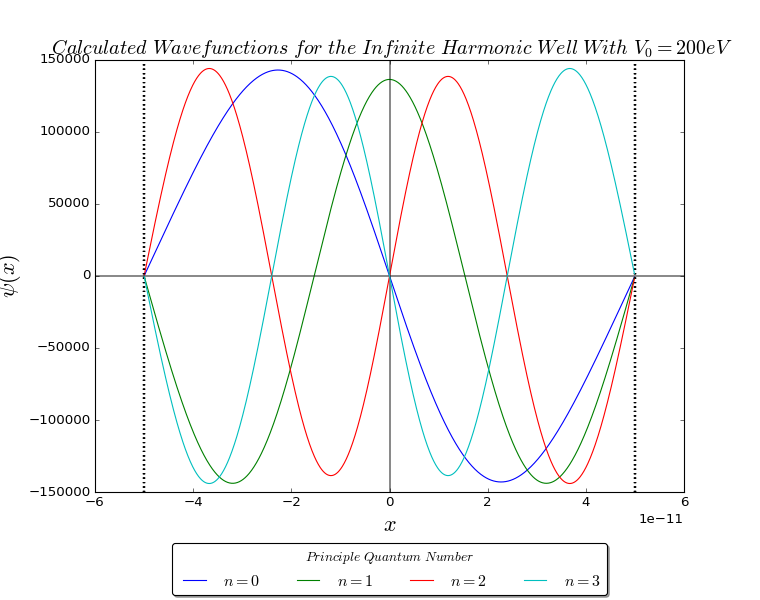

In [36]:
array = [100,150,300,400,600,700,700,800]
plot_all(array,1,4,2)

We can see from this plot that the wavefunction breaks down for lower potentials. It almost seems to be showing more of an infinite square well shape, which would make sense as decreasing $V_0$ to zero would give the same system as an infinite square well.     

# Finite Square Well

The finite square well is defined for: 

$$
V_x = \begin{cases} 0 & \text{if } -a/2 \leq x \leq +a/2, \\ 
    V_0  & \text{if } |x| > a/2, \end{cases} 
$$

Due to the fact that the potential outside the well is not infinite, there will be some probability that the particle can move outside of the well. Here we find one of the fundamental difference between classical and  quantum physics, in a classical regime a particle with energy less than the potential of the well would never be able to escape, hower in a quantum interpretation, it can. The expected plots for these graphs are shown below. As you can see the wavefunction is sinusoidal inside the well, much like our infinite square well, but decays exponentially on either side.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b0/Finite-well-solutions.gif">

We will start with a $V_0$ value of 4000eV (so to hopefully ensure the energy of the particle is lower than $V_0$ for low n) and define a function for our potential.

In [37]:
V0 = 3000

def V(x):
    '''Returns value for potential V for any given x over any range of x.
    Inputs: x, a value or array of x values
    Also requires electronic charge e and well width a to be defined as well as V0 (where
    curve meets x = a and -a)
    Returns: potential V in J
    '''
    
    if  - a/2 < x < a/2:
        V = 0
    else:
        V = V0 * e

    return V

As we do not know given energies, we must try and estimate them.

In [38]:
print('The expected n = 1 state energy is {:.5e} J or {:2.3f} eV'.format(E_secant(0,200,1),E_secant(0,200,1)/e))
print('The expected n = 2 state energy is {:.5e} J or {:2.3f} eV'.format(E_secant(200,350,2),E_secant(200,350,2)/e))
print('The expected n = 3 state energy is {:.5e} J or {:2.3f} eV'.format(E_secant(400,1000,3),E_secant(400,1000,3)/e))
print('The expected n = 4 state energy is {:.5e} J or {:2.3f} eV'.format(E_secant(1000,2000,4),E_secant(1000,2000,4)/e))

The expected n = 1 state energy is 1.84305e-17 J or 115.034 eV
The expected n = 2 state energy is 7.33404e-17 J or 457.755 eV
The expected n = 3 state energy is 1.63377e-16 J or 1019.718 eV
The expected n = 4 state energy is 4.28624e-16 J or 2675.259 eV


<IPython.core.display.Javascript object>


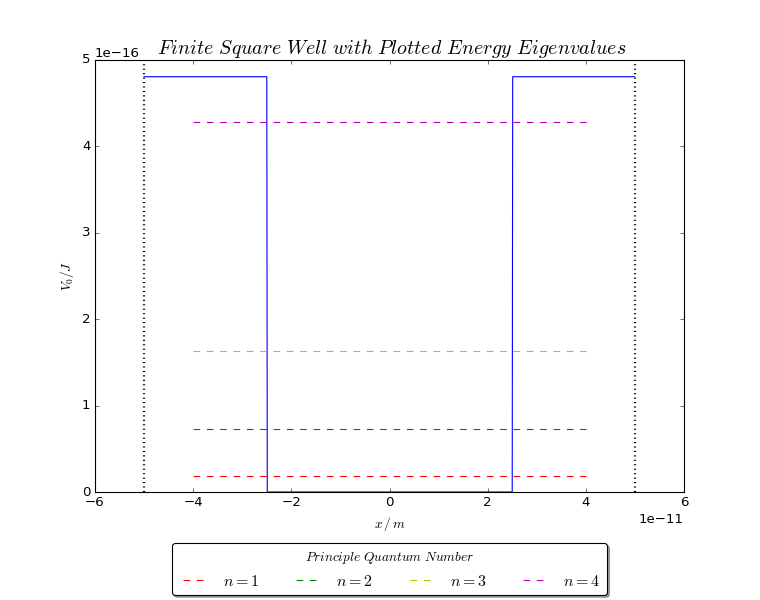

[7.3340398588451075e-17]


In [39]:
plt.figure(figsize=(9.5,7.5))

# plotting potential
potential = [V(x) for x in xpoints]
plt.plot(xpoints,potential)

# calculating energy eigenvalues
y0 = [E_secant(0,200,1)]
y1 = [E_secant(200,350,2)]
y2 = [E_secant(400,1000,3)]
y3 = [E_secant(1000,2000,4)]
print(y1)

# plotting energy eigenvalues
plt.axhline(y=y0, xmin=1/6, xmax=5/6, c="r", ls="--", label="$n = 1$")
plt.axhline(y=y1, xmin=1/6, xmax=5/6, c="g", ls="--", label="$n = 2$")
plt.axhline(y=y2, xmin=1/6, xmax=5/6, c="y", ls="--", label="$n = 3$")
plt.axhline(y=y3, xmin=1/6, xmax=5/6, c="m", ls="--", label="$n = 4$")

# plotting legend
ax = plt.subplot(111)

# resize current axes
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# plot a legend below the axes
ax.legend(loc='upper center',title = '$Principle\ Quantum\ Number$', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

plt.axvline(x=-a, c="k", ls=":",lw=2)           # draw black dotted line at x = -a
plt.axvline(x=a, c="k", ls=":",lw=2)            # draw black dotted line at x = a
#plt.xlim(-1.5*a,1.5*a)                          # plot axes limits
#plt.ylim(0,1.5e-16)

plt.xlabel("$x\,/\,m$")
plt.ylabel("$V_0 / J$")
plt.title('$\ Finite\ Square\ Well\ with\ Plotted\ Energy\ Eigenvalues$', fontsize=18)  

<IPython.core.display.Javascript object>


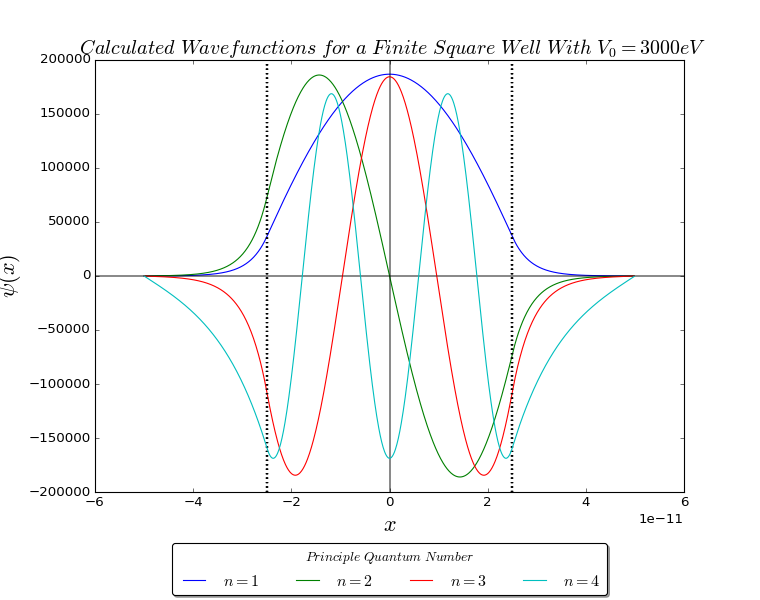

In [40]:
array = [0,200,200,350,400,1000,1000,2000]
plot_all(array,1,4,3)

We can see that this looks simular to the example plot above with a sinusoidal curve almost the same as for infinite square well but with wavefunctions that do not cross the barrier at 0. After this point they exponentially decay.

However the calculated energies seem to show a strange pattern. The n = 2 state has a lower energy that the ground state. Perhaps this indicates our energy guesses are wrong, however after varying the energies (removed to save space) this does not seem to change, so we will keep these estimates for now due to the fact the graph looks correct in comparison to accepted plots.  

But what if the well potential is less than the energy of the particle? We will take two guesses for the energy and see which one fits the shapeof the accepted curves most.

<IPython.core.display.Javascript object>


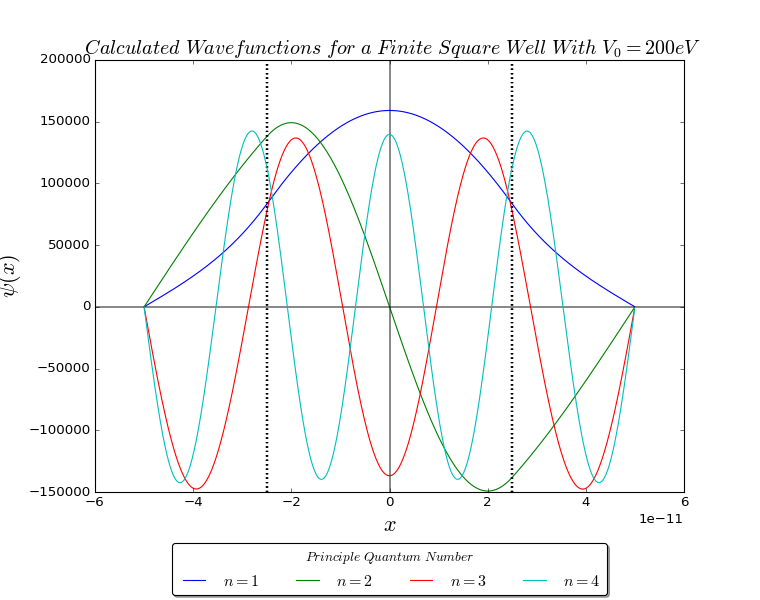

<IPython.core.display.Javascript object>


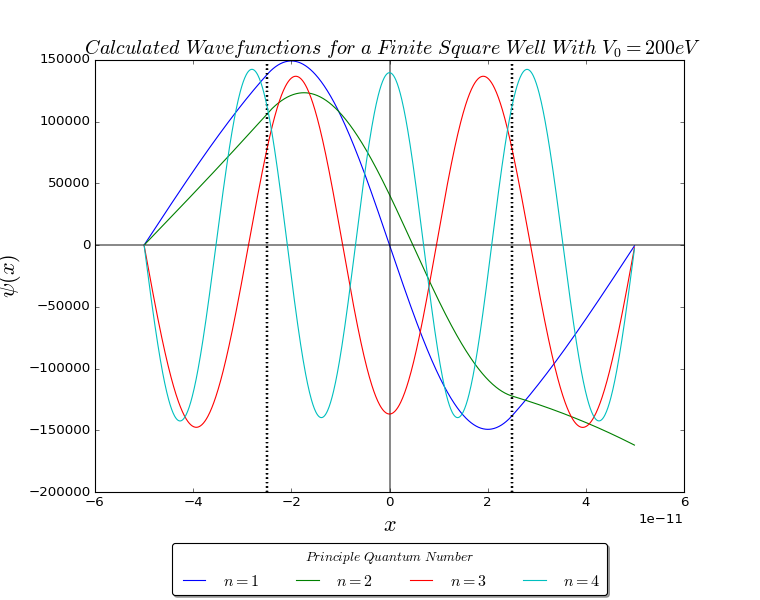

In [41]:
V0 = 200

array = [0,100,100,250,300,900,900,1900]

# in case our energy estimates for the secant calculations are too low, let's increase them
array2 = [0,200,200,350,400,1000,1000,2000]

plot_all(array,1,4,3)
plot_all(array2,1,4,3)

It seems that the first plot is becoming more simular to an infinite square well plot, except  it is not bounded by the well. It seems we care tending towards a particle bounded by a well larger than the larger well width. This is probably analogous with the fact that when a particle has greater energy than its barrier, it can tunnel through. We have not included this fact in our code hence this is most likely why the graphs seem to break down for low $V_0$

# Extra Finite Potential

Instead of codinf for a potential well, we will now code for a potential barrier represented by:
    
$$
V_x = \begin{cases} \frac{2V_0\left | x \right |}{a} & \text{if } -a/2 \leq x \leq +a/2, \\ 
    0  & \text{if } |x| > a/2, \end{cases} 
$$

which essentially forms a barrier with a V-shaped middle. This potential is plotted with energy eigenvalues a few cells below. I have used a $V_0$ value of 500 as this encorporates the lowest 3 eigenenergies over the range of the barrier but the fourth one lies above the potential barrier. This means that hopefully we can see the affect of each different part of the potential barrier on the wavefunctions.

In [42]:
V0 = 500
def V(x):
    '''Returns value for potential V of a V-shaped potential barrier for any given x over any range of x.
    Inputs: x, a value or array of x values
    Also requires electronic charge e and well width a to be defined as well as V0 (where
    curve meets x = a and -a)
    Returns: potential V in J
    '''
    if abs(x) < a/2:
        V = (V0 * e * 2 * abs(x)) / a
    else:
        V = 0

    return V

<IPython.core.display.Javascript object>


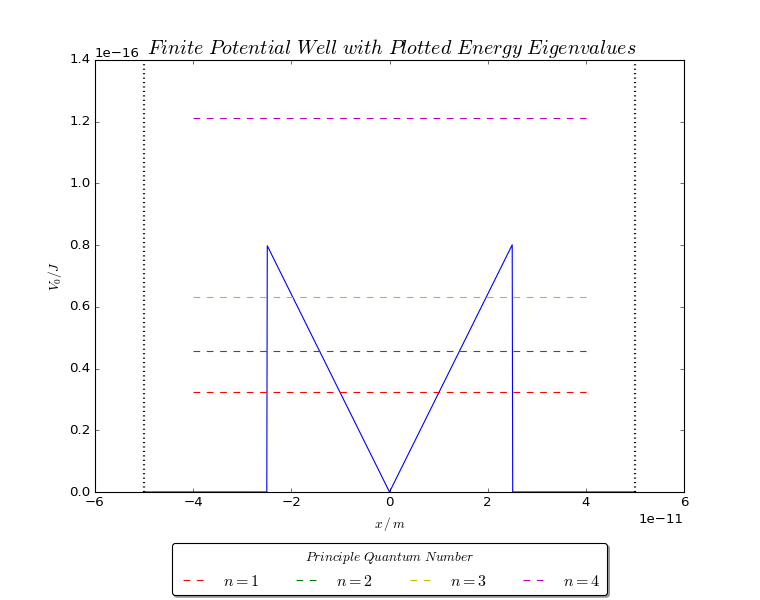

[4.5819107488991204e-17]


In [43]:
plt.figure(figsize=(9.5,7.5))

# plotting potential
potential = [V(x) for x in xpoints]
plt.plot(xpoints,potential)

# calculating energy eigenvalues
y0 = [E_secant(0,100,1)]
y1 = [E_secant(200,300,2)]
y2 = [E_secant(400,500,3)]
y3 = [E_secant(500,600,4)]
print(y1)

# plotting energy eigenvalues
plt.axhline(y=y0, xmin=1/6, xmax=5/6, c="r", ls="--", label="$n = 1$")
plt.axhline(y=y1, xmin=1/6, xmax=5/6, c="g", ls="--", label="$n = 2$")
plt.axhline(y=y2, xmin=1/6, xmax=5/6, c="y", ls="--", label="$n = 3$")
plt.axhline(y=y3, xmin=1/6, xmax=5/6, c="m", ls="--", label="$n = 4$")

# plotting legend
ax = plt.subplot(111)

# resize current axes
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# plot a legend below the axes
ax.legend(loc='upper center',title = '$Principle\ Quantum\ Number$', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

plt.axvline(x=-a, c="k", ls=":",lw=2)           # draw black dotted line at x = -a
plt.axvline(x=a, c="k", ls=":",lw=2)            # draw black dotted line at x = a
#plt.xlim(-1.5*a,1.5*a)                          # plot axes limits
#plt.ylim(0,1.5e-16)

plt.xlabel("$x\,/\,m$")
plt.ylabel("$V_0 / J$")
plt.title('$\ Finite\ Potential\ Well\ with\ Plotted\ Energy\ Eigenvalues$', fontsize=18)  

<IPython.core.display.Javascript object>


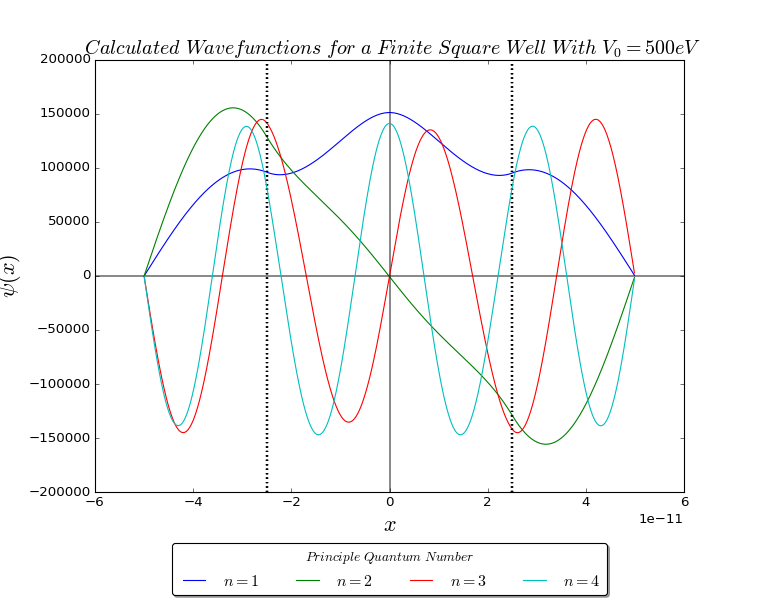

In [44]:
array = [0,100,100,250,300,900,900,1900]
plot_all(array ,1 ,4, 3)

We can see that for each wavefunction, before it reaches the barrier space it behaves as a free particle described by the Schrodinger equation at the very top of this document. When it reaches the potential barrier its amplitude decreases as it passes through, then when it exits the barrier it carries on in the same form as before it initially hit the barrier. This is because when the wavefunction is in within the region of the potential barrier its probability becomes decreased, so the probability of finding the wavefunction at a point past the potential barrier is decreased from what it would have been if there was no potential barrier present.

The wavefunctions with higher principle quantum numbers seem almost unnaffected by the potential barrier as they  take the form of a relatively free partivle type wavefunction the whole way through increasing x values. We can see that the n = 1 and 2 potentials are affected most by the barrier, the probabilites of finding them in a position after the potential barrier are decreased most.

# Referances

[1]  David J. Griffiths, ‘Introduction to Quantum Mechanics’, 2nd ed. Pearson, 2005 

[2]  K. F. Riley, 'Mathematical Method for Physics and Enginerring', 3rd ed. Cambridge, 2006

[3]  Serway & Jewett, 'Physics for Scientists and Engineers', 9th ed. Brooks/Cole, 2014  